# AIRLINE ARRIVAL PROJECT

# I. Introduction 

This dataset of airline arrival information to predict how late flights will be. 

A flight only counts as late if it is more than 30 minutes late.

# II. Data description

http://stat-computing.org/dataexpo/2009/the-data.html

    1	Year	            1987-2008
    2	Month	            1-12
    3	DayofMonth	        1-31
    4	DayOfWeek	        1 (Monday) - 7 (Sunday)
    5	DepTime	            actual departure time (local, hhmm)
    6	CRSDepTime	        scheduled departure time (local, hhmm)
    7	ArrTime	            actual arrival time (local, hhmm)
    8	CRSArrTime	        scheduled arrival time (local, hhmm)
    9	UniqueCarrier	    unique carrier code
    10	FlightNum	        flight number
    11	TailNum	            plane tail number
    12	ActualElapsedTime	in minutes
    13	CRSElapsedTime	    in minutes
    14	AirTime	            in minutes
    15	ArrDelay	        arrival delay, in minutes
    16	DepDelay	        departure delay, in minutes
    17	Origin	            origin IATA airport code
    18	Dest	            destination IATA airport code
    19	Distance	        in miles
    20	TaxiIn	            taxi in time, in minutes
    21	TaxiOut	            taxi out time in minutes
    22	Cancelled	        was the flight cancelled?
    23	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
    24	Diverted	        1 = yes, 0 = no
    25	CarrierDelay	    in minutes
    26	WeatherDelay	    in minutes
    27	NASDelay	        in minutes
    28	SecurityDelay	    in minutes
    29	LateAircraftDelay	in minutes

# III. Content 

In [90]:
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, classification_report

from math import sqrt
import seaborn as sns

### Since the data is too large (7 million samples), the following codes will present only 1 million random samples extracted from the '2008.csv'

In [2]:
num_lines = 7009728  #number of records in file
sample_lines = 1000000 #desired sample size

random.seed(9001)
skip = random.sample(range(1, num_lines), num_lines - sample_lines)
df = pd.read_csv('D:\\Nhat\\ML course\\Assignment\\cac\\2008.csv', skiprows=skip)

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = "{:.2f}".format
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,628.00,620,804.00,750,WN,448,N428WN,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,3.00,17.00,0,NaN,0,nan,nan,nan,nan,nan
1,2008,1,3,4,1644.00,1510,1845.00,1725,WN,1333,N334SW,121.00,135.00,107.00,80.00,94.00,IND,MCO,828,6.00,8.00,0,NaN,0,8.00,0.00,0.00,0.00,72.00
2,2008,1,3,4,636.00,635,921.00,945,WN,2275,N454WN,165.00,190.00,147.00,-24.00,1.00,ISP,FLL,1093,5.00,13.00,0,NaN,0,nan,nan,nan,nan,nan
3,2008,1,3,4,2107.00,1945,2334.00,2230,WN,362,N798SW,147.00,165.00,134.00,64.00,82.00,ISP,MCO,972,6.00,7.00,0,NaN,0,5.00,0.00,0.00,0.00,59.00
4,2008,1,3,4,726.00,720,958.00,1020,WN,3319,N206WN,152.00,180.00,140.00,-22.00,6.00,ISP,PBI,1052,4.00,8.00,0,NaN,0,nan,nan,nan,nan,nan


# 1. Data exploration

### missing values

In [4]:
types = df.dtypes.to_frame().rename(columns={0:'dtypes'})
null = df.isnull().sum().to_frame().rename(columns={0:'missing values'})
null_percent = (df.isnull().sum()/df.shape[0]*100).to_frame().rename(columns={0:'% missing values'})
df_missing = pd.concat([types, null, null_percent], axis=1)
df_missing

,dtypes,missing values,% missing values
Year,int64,0,0.00
Month,int64,0,0.00
DayofMonth,int64,0,0.00
DayOfWeek,int64,0,0.00
DepTime,float64,19412,1.94
CRSDepTime,int64,0,0.00
ArrTime,float64,21608,2.16
CRSArrTime,int64,0,0.00
UniqueCarrier,object,0,0.00
FlightNum,int64,0,0.00


### there are 6 features with missing samples > 60% of total samples

In [5]:
missing = df_missing[df_missing['% missing values'] > 0]
missing

,dtypes,missing values,% missing values
DepTime,float64,19412,1.94
ArrTime,float64,21608,2.16
TailNum,object,11914,1.19
ActualElapsedTime,float64,22058,2.21
CRSElapsedTime,float64,142,0.01
AirTime,float64,22058,2.21
ArrDelay,float64,22058,2.21
DepDelay,float64,19412,1.94
TaxiIn,float64,21608,2.16
TaxiOut,float64,19532,1.95


### These 6 features will be removed

In [6]:
df1 = df.drop(columns=missing[missing['% missing values'] > 60].index)

### All other features has < 10% missing samples, all these samples will be removed

In [7]:
df1.isnull().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime              19412
CRSDepTime               0
ArrTime              21608
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum              11914
ActualElapsedTime    22058
CRSElapsedTime         142
AirTime              22058
ArrDelay             22058
DepDelay             19412
Origin                   0
Dest                     0
Distance                 0
TaxiIn               21608
TaxiOut              19532
Cancelled                0
Diverted                 0
dtype: int64

### remove the missing samples

In [8]:
df2 = df1.dropna().reset_index(drop=True)

# 2. Feature selection

### These features 'Cancelled', 'Diverted', 'Year' has only 1 unique value, which will be useless for training               
### -> remove

In [9]:
df2.Cancelled.value_counts()

0    977941
Name: Cancelled, dtype: int64

In [10]:
df2.Diverted.value_counts()

0    977941
Name: Diverted, dtype: int64

In [11]:
df2.Year.value_counts()

2008    977941
Name: Year, dtype: int64

### converting 'FlightNum' to caterigorical feature 

In [12]:
df2.FlightNum = df2.FlightNum.astype('object')
df2.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
count,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00
mean,2008.00,6.39,15.75,3.92,1334.04,1325.41,1481.18,1493.61,127.30,129.08,104.01,8.09,9.87,728.73,6.86,16.43,0.00,0.00
std,0.00,3.40,8.80,1.99,478.29,464.60,505.26,482.96,70.21,69.57,67.46,38.24,34.95,563.30,4.92,11.28,0.00,0.00
min,2008.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,15.00,-140.00,0.00,-519.00,-534.00,21.00,0.00,0.00,0.00,0.00
25%,2008.00,3.00,8.00,2.00,928.00,925.00,1107.00,1115.00,77.00,80.00,55.00,-10.00,-4.00,326.00,4.00,10.00,0.00,0.00
50%,2008.00,6.00,16.00,4.00,1326.00,1320.00,1512.00,1515.00,109.00,111.00,86.00,-2.00,-1.00,581.00,6.00,14.00,0.00,0.00
75%,2008.00,9.00,23.00,6.00,1728.00,1715.00,1908.00,1905.00,157.00,159.00,132.00,12.00,8.00,954.00,8.00,19.00,0.00,0.00
max,2008.00,12.00,31.00,7.00,2400.00,2359.00,2400.00,2359.00,802.00,660.00,757.00,1392.00,1369.00,4962.00,225.00,393.00,0.00,0.00


### feature 'FlightNum' and 'TailNum' has >> 500 unique values, thus will have no effect on the target 
### -> remove

In [13]:
df2.describe(include='O')

,UniqueCarrier,FlightNum,TailNum,Origin,Dest
count,977941,977941,977941,977941,977941
unique,20,7472,5328,302,302
top,WN,152,N476HA,ATL,ATL
freq,169752,705,697,58078,57823


In [14]:
df3 = df2.drop(columns=['Year','Cancelled','Diverted', 'FlightNum', 'TailNum'])

### data before and after modification

In [15]:
df.shape

(1000000, 29)

In [16]:
df3.shape

(977941, 18)

### The target 'ArrDelay' is converted to 1 (delay > 30 mins) and 0 (delay <= 30 mins) 

In [17]:
df3.ArrDelay = df3.ArrDelay.apply(lambda x: 1 if x > 30 else 0)

In [18]:
df3.ArrDelay.value_counts()

0    849555
1    128386
Name: ArrDelay, dtype: int64

In [19]:
df3.groupby('ArrDelay').mean()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut
ArrDelay,,,,,,,,,,,,,,
0,6.44,15.75,3.92,1298.79,1301.35,1462.68,1469.73,124.79,128.24,102.93,0.53,724.66,6.69,15.16
1,6.08,15.73,3.97,1567.30,1484.59,1603.55,1651.62,143.90,134.61,111.10,71.68,755.70,7.97,24.83


### there is no unsual values in the numeric features

In [20]:
df3.describe()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
count,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00,977941.00
mean,6.39,15.75,3.92,1334.04,1325.41,1481.18,1493.61,127.30,129.08,104.01,0.13,9.87,728.73,6.86,16.43
std,3.40,8.80,1.99,478.29,464.60,505.26,482.96,70.21,69.57,67.46,0.34,34.95,563.30,4.92,11.28
min,1.00,1.00,1.00,1.00,1.00,1.00,0.00,15.00,-140.00,0.00,0.00,-534.00,21.00,0.00,0.00
25%,3.00,8.00,2.00,928.00,925.00,1107.00,1115.00,77.00,80.00,55.00,0.00,-4.00,326.00,4.00,10.00
50%,6.00,16.00,4.00,1326.00,1320.00,1512.00,1515.00,109.00,111.00,86.00,0.00,-1.00,581.00,6.00,14.00
75%,9.00,23.00,6.00,1728.00,1715.00,1908.00,1905.00,157.00,159.00,132.00,0.00,8.00,954.00,8.00,19.00
max,12.00,31.00,7.00,2400.00,2359.00,2400.00,2359.00,802.00,660.00,757.00,1.00,1369.00,4962.00,225.00,393.00


### there is no unsual values in the numeric features

In [21]:
df3.describe(include='O')

,UniqueCarrier,Origin,Dest
count,977941,977941,977941
unique,20,302,302
top,WN,ATL,ATL
freq,169752,58078,57823


### check for correlation in numerical feature 

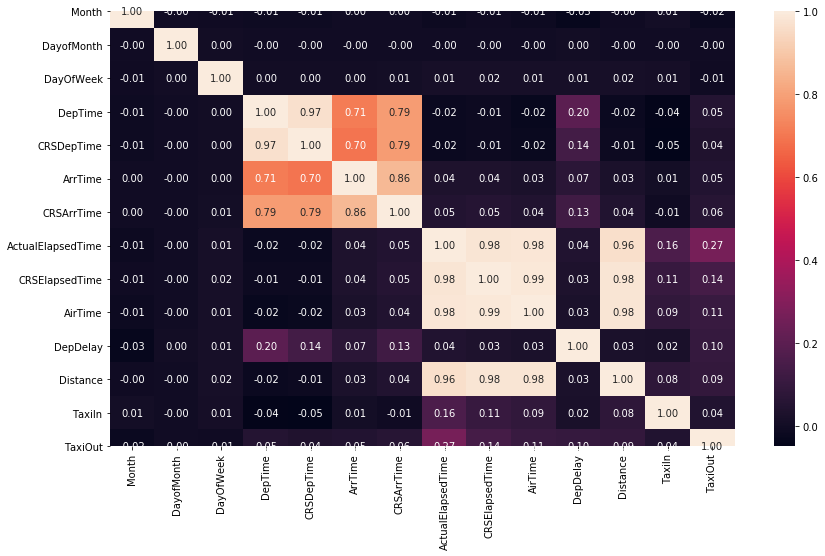

In [22]:
plt.figure(figsize=(14,8))
sns.heatmap(df3.drop(columns='ArrDelay').select_dtypes(np.number).corr(), annot=True, fmt=".2f")
plt.show()

# 3. Data visulization 

In [23]:
yes_delay = df3[df3.ArrDelay == 1]
no_delay = df3[df3.ArrDelay == 0]

### comparision between delay and not delay with respect to 'Month', 'DayOfWeek', 'DayofMonth'

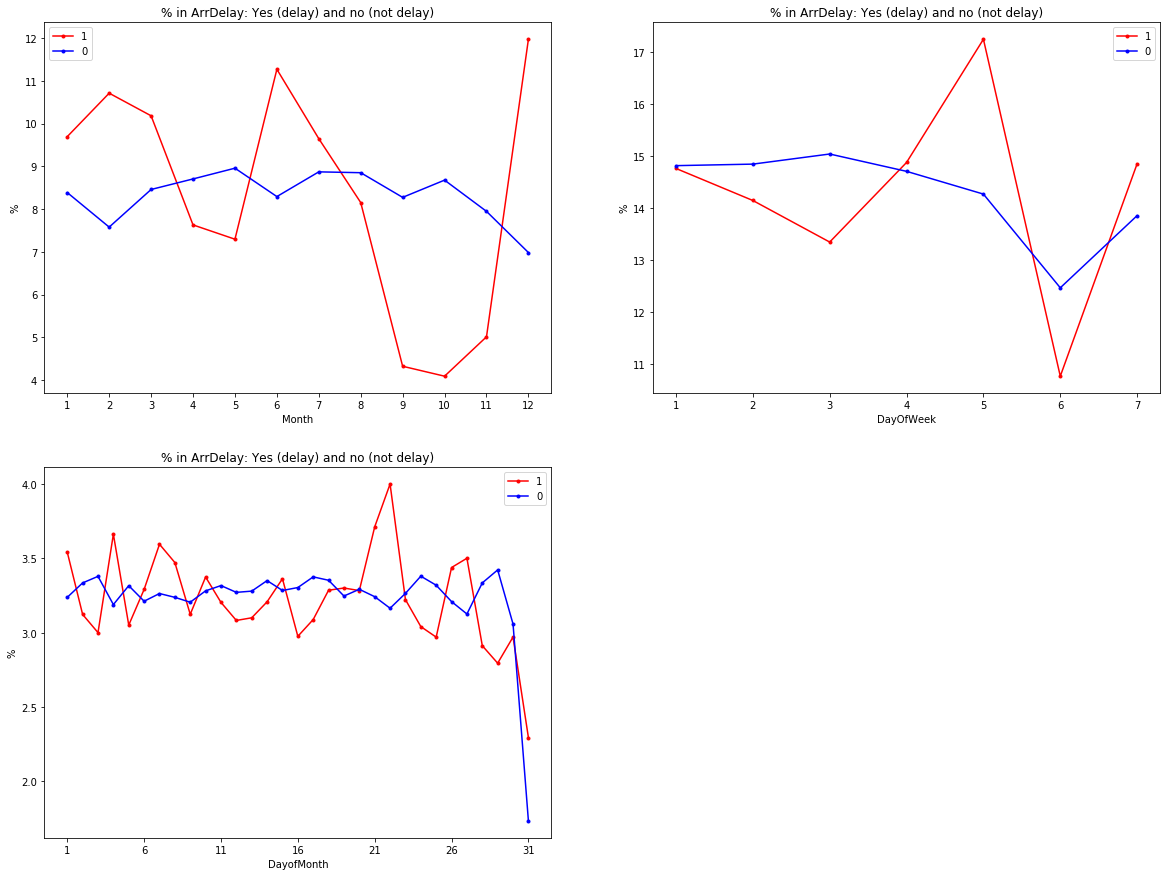

In [24]:
plt.figure(num=1, figsize=(20,15))

plt.subplot(221)

x1 = yes_delay.Month.value_counts().sort_index().index
y1 = yes_delay.Month.value_counts().sort_index()/yes_delay.shape[0]*100
x2 = no_delay.Month.value_counts().sort_index().index
y2 = no_delay.Month.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('Month')
plt.ylabel('%')
plt.xticks(range(1,13))
plt.plot(x1,y1, '.-', label='1', color='r')
plt.plot(x2,y2, '.-', label='0', color='b')
plt.legend()

plt.subplot(222)
x3 = yes_delay.DayOfWeek.value_counts().sort_index().index
y3 = yes_delay.DayOfWeek.value_counts().sort_index()/yes_delay.shape[0]*100
x4 = no_delay.DayOfWeek.value_counts().sort_index().index
y4 = no_delay.DayOfWeek.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('DayOfWeek')
plt.ylabel('%')
plt.xticks(range(1,8))
plt.plot(x3,y3, '.-', label='1', color='r')
plt.plot(x4,y4, '.-', label='0', color='b')
plt.legend()

plt.subplot(223)
x5 = yes_delay.DayofMonth.value_counts().sort_index().index
y5 = yes_delay.DayofMonth.value_counts().sort_index()/yes_delay.shape[0]*100
x6 = no_delay.DayofMonth.value_counts().sort_index().index
y6 = no_delay.DayofMonth.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('DayofMonth')
plt.ylabel('%')
plt.xticks(range(1,32,5))
plt.plot(x5,y5, '.-', label='1', color='r')
plt.plot(x6,y6, '.-', label='0', color='b')
plt.legend()
plt.show()

### comparision between delay and not delay with respect to 'DepTime' and 'CRSDepTime', 'ArrTime' and 'CRSArrTime'

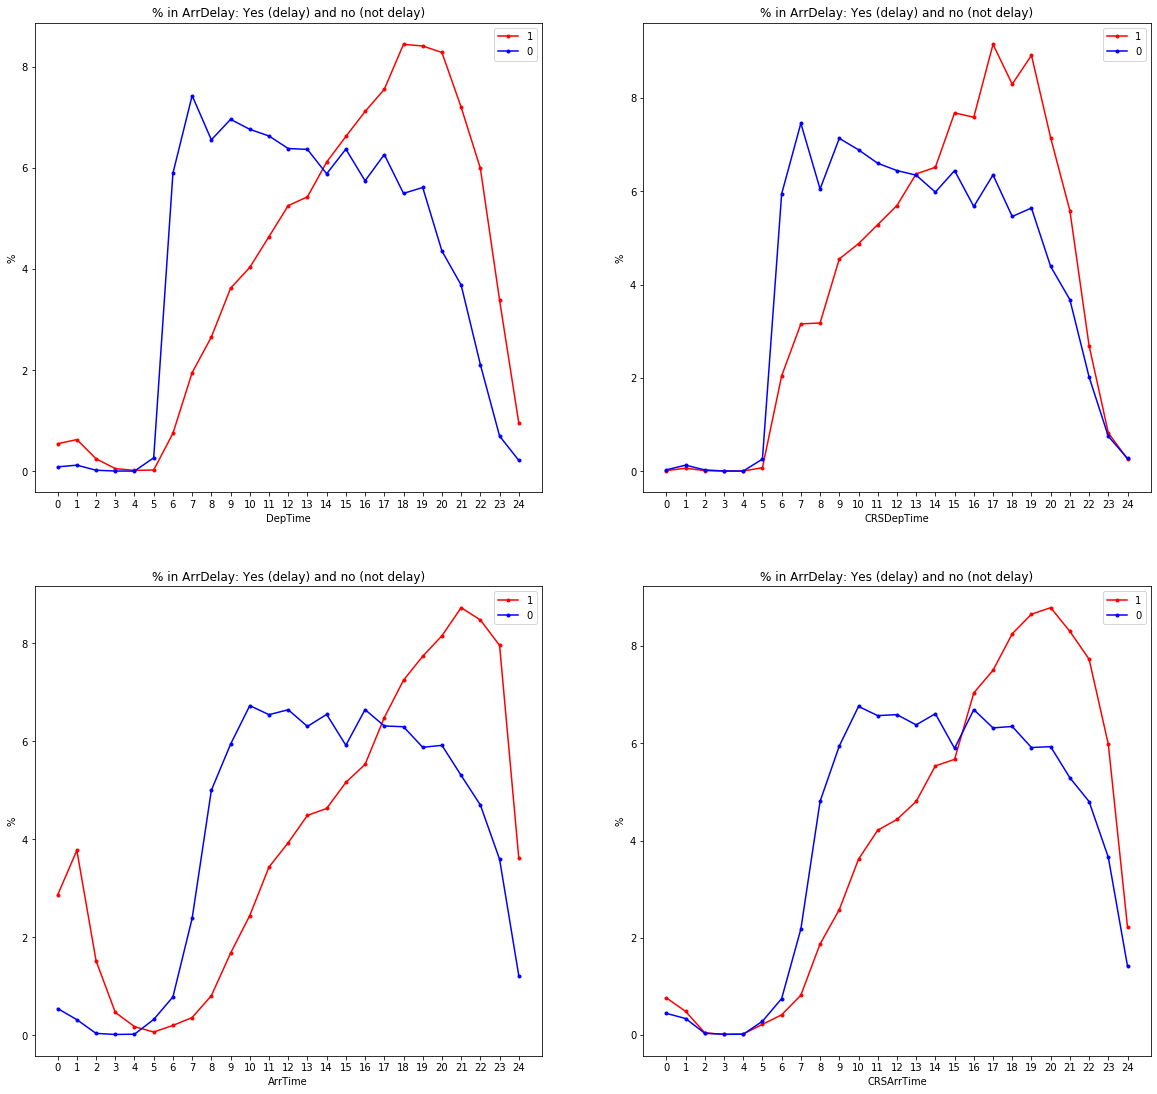

In [25]:
plt.figure(num=2, figsize=(20,19))

yes = (yes_delay[['DepTime','CRSDepTime', 'ArrTime','CRSArrTime']]/100)
no = (no_delay[['DepTime','CRSDepTime', 'ArrTime','CRSArrTime']]/100)
yes.DepTime = yes.DepTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
no.DepTime= no.DepTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
yes.CRSDepTime= yes.CRSDepTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
no.CRSDepTime= no.CRSDepTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
yes.ArrTime = yes.ArrTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
no.ArrTime= no.ArrTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
yes.CRSArrTime = yes.CRSArrTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))
no.CRSArrTime= no.CRSArrTime.apply(lambda x: int(x)+1 if (x-int(x)) >= 0.3 else int(x))

plt.subplot(221)

x1 = yes.DepTime.value_counts().sort_index().index
y1 = yes.DepTime.value_counts().sort_index()/yes_delay.shape[0]*100
x2 = no.DepTime.value_counts().sort_index().index
y2 = no.DepTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('DepTime')
plt.ylabel('%')
plt.xticks(range(0,25))
plt.plot(x1,y1, '.-', label='1', color='r')
plt.plot(x2,y2, '.-', label='0', color='b')
plt.legend()

plt.subplot(222)
x3 = yes.CRSDepTime.value_counts().sort_index().index
y3 = yes.CRSDepTime.value_counts().sort_index()/yes_delay.shape[0]*100
x4 = no.CRSDepTime.value_counts().sort_index().index
y4 = no.CRSDepTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('CRSDepTime')
plt.ylabel('%')
plt.xticks(range(0,25))
plt.plot(x3,y3, '.-', label='1', color='r')
plt.plot(x4,y4, '.-', label='0', color='b')
plt.legend()

plt.subplot(223)
x5 = yes.ArrTime.value_counts().sort_index().index
y5 = yes.ArrTime.value_counts().sort_index()/yes_delay.shape[0]*100
x6 = no.ArrTime.value_counts().sort_index().index
y6 = no.ArrTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('ArrTime')
plt.ylabel('%')
plt.xticks(range(0,25))
plt.plot(x5,y5, '.-', label='1', color='r')
plt.plot(x6,y6, '.-', label='0', color='b')
plt.legend()

plt.subplot(224)
x7 = yes.CRSArrTime.value_counts().sort_index().index
y7 = yes.CRSArrTime.value_counts().sort_index()/yes_delay.shape[0]*100
x8 = no.CRSArrTime.value_counts().sort_index().index
y8 = no.CRSArrTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('CRSArrTime')
plt.ylabel('%')
plt.xticks(range(0,25))
plt.plot(x7,y7, '.-', label='1', color='r')
plt.plot(x8,y8, '.-', label='0', color='b')
plt.legend()

plt.show()

### -> the correlation between 'DepTime' and 'CRSDepTime', 'ArrTime' and 'CRSArrTime' are significant

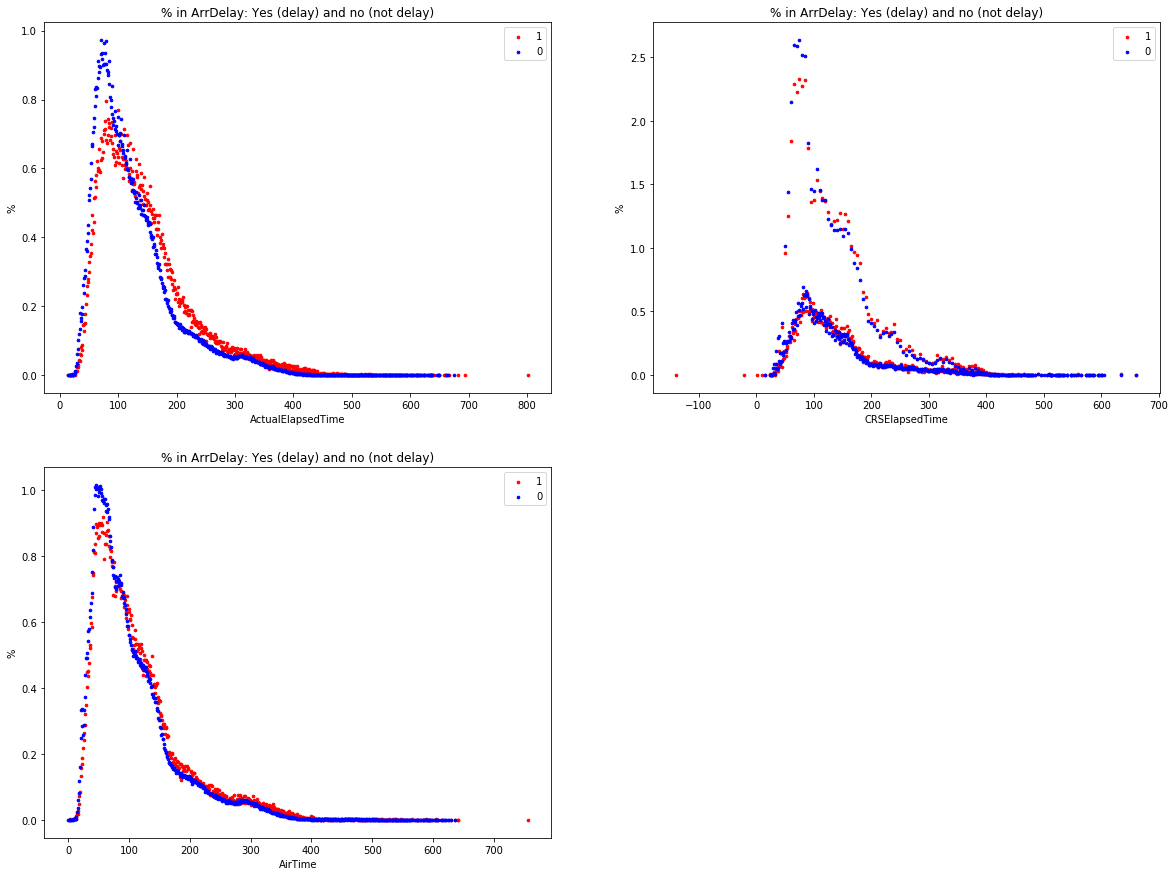

In [26]:
plt.figure(num=3, figsize=(20,15))

plt.subplot(221)

x1 = yes_delay.ActualElapsedTime.value_counts().sort_index().index
y1 = yes_delay.ActualElapsedTime.value_counts().sort_index()/yes_delay.shape[0]*100
x2 = no_delay.ActualElapsedTime.value_counts().sort_index().index
y2 = no_delay.ActualElapsedTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('ActualElapsedTime')
plt.ylabel('%')
#plt.xticks(range(1,13))
plt.scatter(x1,y1, label='1', color='r', s=7)
plt.scatter(x2,y2, label='0', color='b', s=7)
plt.legend()

plt.subplot(222)
x3 = yes_delay.CRSElapsedTime.value_counts().sort_index().index
y3 = yes_delay.CRSElapsedTime.value_counts().sort_index()/yes_delay.shape[0]*100
x4 = no_delay.CRSElapsedTime.value_counts().sort_index().index
y4 = no_delay.CRSElapsedTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('CRSElapsedTime')
plt.ylabel('%')
#plt.xticks(range(1,8))
plt.scatter(x3,y3, label='1', color='r', s=7)
plt.scatter(x4,y4, label='0', color='b', s=7)
plt.legend()

plt.subplot(223)
x5 = yes_delay.AirTime.value_counts().sort_index().index
y5 = yes_delay.AirTime.value_counts().sort_index()/yes_delay.shape[0]*100
x6 = no_delay.AirTime.value_counts().sort_index().index
y6 = no_delay.AirTime.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('AirTime')
plt.ylabel('%')
#plt.xticks(range(1,32,5))
plt.scatter(x5,y5, label='1', color='r', s=7)
plt.scatter(x6,y6, label='0', color='b', s=7)
plt.legend()

plt.show()

### DepDelay has a significant effect on the result of 'ArrDelay'

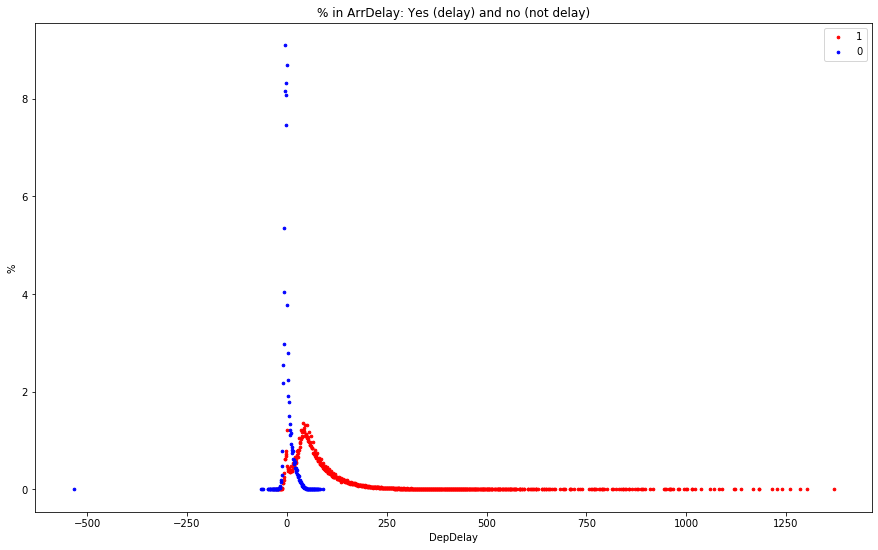

In [27]:
plt.figure(num=4, figsize=(15,9))

x1 = yes_delay.DepDelay.value_counts().sort_index().index
y1 = yes_delay.DepDelay.value_counts().sort_index()/yes_delay.shape[0]*100
x2 = no_delay.DepDelay.value_counts().sort_index().index
y2 = no_delay.DepDelay.value_counts().sort_index()/no_delay.shape[0]*100
plt.title('% in ArrDelay: Yes (delay) and no (not delay)')
plt.xlabel('DepDelay')
plt.ylabel('%')
plt.scatter(x1,y1, label='1', color='r', s=7)


plt.scatter(x2,y2, label='0', color='b', s=7)
plt.legend()
plt.show()

# 4. Data training 

## 4.1 Data preprocessing

## apply one-hot encoding to categorical feature, apply StandardScaler to numeric features 

### non-scaled features

In [94]:
feature = df3.drop(columns='ArrDelay')
target = df3.ArrDelay

### numeric and categorical feature

In [29]:
num_feature = feature.select_dtypes(np.number)
cat_feature = feature.select_dtypes(object)

In [96]:
# one-hot encode categorical features, we drop the 'Origin' and 'Dest' feature due to 'Memory error'
ohe_cat_feature = pd.get_dummies(cat_feature.drop(columns=['Origin','Dest']), drop_first=True)

#standardscale numeric feature
scaled_num_feature = pd.DataFrame(StandardScaler().fit_transform(num_feature), columns=num_feature.columns)

### our scaled feature has 33 features

In [52]:
new_feature = pd.concat([scaled_num_feature, ohe_cat_feature], axis=1)
new_feature

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,-1.59,-1.45,0.04,-1.48,-1.52,-1.34,-1.54,-0.45,-0.56,-0.42,-0.05,-0.38,-0.78,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.59,-1.45,0.04,0.65,0.40,0.72,0.48,-0.09,0.09,0.04,2.41,0.18,-0.17,-0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-1.59,-1.45,0.04,-1.46,-1.49,-1.11,-1.14,0.54,0.88,0.64,-0.25,0.65,-0.38,-0.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-1.59,-1.45,0.04,1.62,1.33,1.69,1.52,0.28,0.52,0.44,2.06,0.43,-0.17,-0.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-1.59,-1.45,0.04,-1.27,-1.30,-1.04,-0.98,0.35,0.73,0.53,-0.11,0.57,-0.58,-0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977936,1.65,-0.31,1.04,-1.03,-1.04,-0.90,-0.98,-0.32,-0.45,-0.76,-0.37,-0.60,-0.17,2.62,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
977937,1.65,-0.31,1.04,-1.46,-1.48,-1.33,-1.53,-0.53,-0.81,-0.80,-0.34,-0.81,1.45,0.85,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
977938,1.65,-0.31,1.04,-1.42,-1.35,-1.24,-1.32,-0.09,-0.19,-0.28,-0.43,-0.33,3.49,-0.39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
977939,1.65,-0.31,1.04,-0.17,-0.18,-0.07,-0.12,-0.18,-0.17,-0.22,0.03,-0.35,1.25,-0.30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### split train-test with one-hot encode

In [53]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_feature, target.values.reshape(-1,1), test_size=0.2, random_state=0)

## 4.2 Train the model 

### 4.2.1. Logistic Regression

In [116]:
lr = LogisticRegression(C=1)
lr.fit(X_train1,y_train1)

D:\Nhat\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Nhat\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### accuracy on the test set

In [117]:
lr.score(X_test1, y_test1)

0.9998415043790806

### accuracy on the test set

In [118]:
lr.score(X_train1, y_train1)

0.9998862404646501

### f1-score 

In [119]:
lr_y_pred = lr.predict(X_test1)
f1_score(y_test1, lr_y_pred)

0.9993974849857146

### f1-score, precision and recall

In [120]:
print(classification_report(y_test1, lr_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169849
           1       1.00      1.00      1.00     25740

    accuracy                           1.00    195589
   macro avg       1.00      1.00      1.00    195589
weighted avg       1.00      1.00      1.00    195589



### 4.2.2. Random Forest

In [91]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train1, y_train1)

C:\Users\TRU\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


### accuracy on the test set

In [121]:
rfc.score(X_test1, y_test1)

0.9771715178256446

### accuracy on the train set 

In [122]:
rfc.score(X_train1, y_train1)

0.998656614925251

### f1-score

In [125]:
rfc_y_pred = rfc.predict(X_test1)
f1_score(y_test1, rfc_y_pred)

0.9093345787560664

### f1-score, precision and recall

In [126]:
print(classification_report(y_test1, rfc_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    169849
           1       0.95      0.87      0.91     25740

    accuracy                           0.98    195589
   macro avg       0.97      0.93      0.95    195589
weighted avg       0.98      0.98      0.98    195589



### 4.2.3. Decision Tree

### We will use LabelEncoder for the categorical features when training with Decision Tree and Naive Bayes

In [130]:
# apply LabelEncoder for categorical feature
le = LabelEncoder()
UniqueCarrier = le.fit_transform(cat_feature.UniqueCarrier).reshape(-1,1)
Origin = le.fit_transform(cat_feature.Origin).reshape(-1,1)
Dest = le.fit_transform(cat_feature.Dest).reshape(-1,1)

# concat the numeric and categorical features
le_cat_feature = np.concatenate([UniqueCarrier,Origin, Dest], axis=1)
le_feature = np.concatenate([num_feature.values, le_cat_feature], axis=1)

### le_feature has 17 features 

In [131]:
le_feature.shape

(977941, 17)

### split the data set 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(le_feature, target.values.reshape(-1,1), test_size=0.2, random_state=0)

In [133]:
model_tree = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### accuracy on the train set  

In [134]:
model_tree.score(X_train,y_train)

0.9968990940139477

### accuracy on the test set 

In [135]:
model_tree.score(X_test,y_test)

0.9845134440075873

### f1-score 

In [137]:
tree_y_pred = model_tree.predict(X_test)
f1_score(tree_y_pred, y_test)

0.9409425022909396

### f1-score, precision and recall 

In [138]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169849
           1       0.94      0.94      0.94     25740

    accuracy                           0.98    195589
   macro avg       0.97      0.96      0.97    195589
weighted avg       0.98      0.98      0.98    195589



### 4.2.4. Naive Bayes 

In [140]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)


D:\Nhat\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

### accuracy on the train set 

In [47]:
gnb.score(X_train, y_train)

0.9441517373253983

### accuracy on the test set 

In [95]:
gnb.score(X_test, y_test)

0.9441430755308325

### f1-score 

In [141]:
gnb_y_pred = gnb.predict(X_test)
f1_score(gnb_y_pred, y_test)

0.8090402195382007

### f1-score, precision and recall 

In [142]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169849
           1       0.94      0.94      0.94     25740

    accuracy                           0.98    195589
   macro avg       0.97      0.96      0.97    195589
weighted avg       0.98      0.98      0.98    195589

